In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt

In [17]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [18]:
print(data_dir)

C:\Users\samwi\.keras\datasets\flower_photos


In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


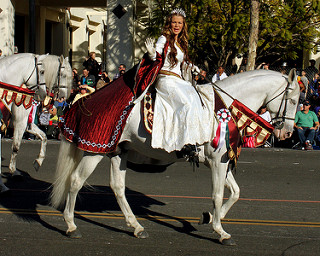

In [20]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[11]))

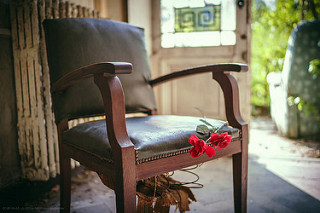

In [21]:
PIL.Image.open(str(roses[200]))

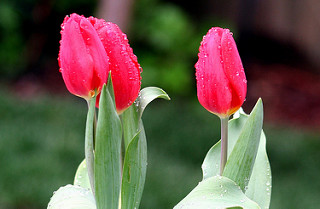

In [22]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

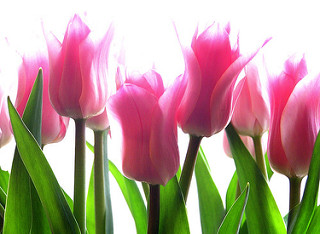

In [23]:
PIL.Image.open(str(tulips[13]))

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [44]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [64]:
class_names = train_ds.class_names
print(class_names)

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

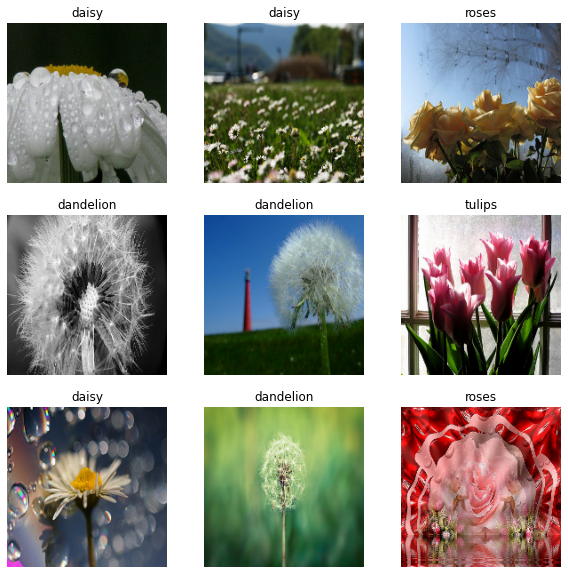

In [46]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


In [57]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [58]:
normalization_layer = layers.Rescaling(1./255)
print(type(normalization_layer))

<class 'keras.layers.preprocessing.image_preprocessing.Rescaling'>


In [61]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [62]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [63]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
92/92 [==============================] - 50s 529ms/step - loss: 1.4131 - accuracy: 0.4101 - val_loss: 1.0990 - val_accuracy: 0.5586
Epoch 2/10
92/92 [==============================] - 48s 524ms/step - loss: 1.0476 - accuracy: 0.5851 - val_loss: 0.9927 - val_accuracy: 0.6104
Epoch 3/10
92/92 [==============================] - 47s 509ms/step - loss: 0.8680 - accuracy: 0.6669 - val_loss: 0.8796 - val_accuracy: 0.6621
Epoch 4/10
92/92 [==============================] - 48s 526ms/step - loss: 0.6912 - accuracy: 0.7411 - val_loss: 0.9154 - val_accuracy: 0.6499
Epoch 5/10
92/92 [==============================] - 47s 513ms/step - loss: 0.4871 - accuracy: 0.8225 - val_loss: 0.9408 - val_accuracy: 0.6594
Epoch 6/10
92/92 [==============================] - 45s 494ms/step - loss: 0.2994 - accuracy: 0.9022 - val_loss: 1.0003 - val_accuracy: 0.6812
Epoch 7/10
92/92 [==============================] - 45s 488ms/step - loss: 0.1569 - accuracy: 0.9520 - val_loss: 1.2295 - val_accuracy: 0.6362

In [77]:
model.evaluate(val_ds)

23/23 [==============================] - 3s 120ms/step - loss: 2.4629 - accuracy: 0.6703


[2.4629063606262207, 0.6702997088432312]

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

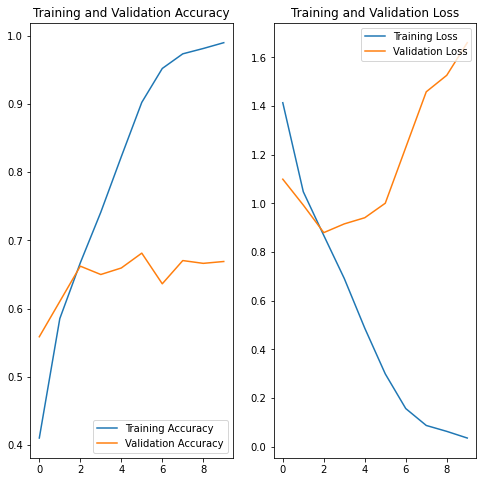

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
num_classes = len(class_names)

model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [71]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model1.fit(train_ds,epochs=5)

Epoch 1/5
92/92 [==============================] - 42s 448ms/step - loss: 1.3230 - accuracy: 0.4315
Epoch 2/5
92/92 [==============================] - 41s 446ms/step - loss: 0.9889 - accuracy: 0.6138
Epoch 3/5
92/92 [==============================] - 41s 448ms/step - loss: 0.8119 - accuracy: 0.6989
Epoch 4/5
92/92 [==============================] - 42s 455ms/step - loss: 0.5934 - accuracy: 0.7796
Epoch 5/5
92/92 [==============================] - 43s 467ms/step - loss: 0.4208 - accuracy: 0.8471


In [74]:
model1.evaluate(train_ds)

92/92 [==============================] - 12s 131ms/step - loss: 0.2556 - accuracy: 0.9237


[0.2555997967720032, 0.9237056970596313]

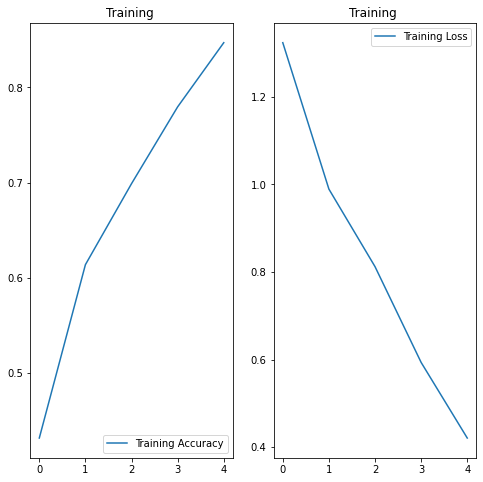

In [79]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training ')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training ')
plt.show()